In [1]:
import re, numpy as np, pandas as pd

PATH = "6W3C_dephos_Hb_50ns.csv"  # <- change to your file

txt = open(PATH, "r", encoding="utf-8", errors="ignore").read()

# extract meta
def get_num(key):
    m = re.search(rf"{key}\s*=\s*([-+]?\d+(?:\.\d+)?)", txt)
    return float(m.group(1)) if m else None

nframes = get_num("TrajectoryNumFrames")
interval_ps = get_num("TrajectoryInterval_ps")

# extract all atom pairs [i j]
pairs = re.findall(r"\[\s*(\d+)\s+(\d+)\s*\]", txt)
pairs = [(int(a), int(b)) for a,b in pairs]

# count occurrences per pair and compute occupancy
from collections import Counter
ctr = Counter(pairs)
df = pd.DataFrame([(a,b,c) for (a,b),c in ctr.items()], columns=["atom_i","atom_j","occurrences"])
if nframes:
    df["occupancy"] = df["occurrences"] / nframes
df = df.sort_values("occupancy", ascending=False, kind="mergesort")

print(f"Frames: {nframes} | interval: {interval_ps} ps | unique pairs: {len(df)}")
if nframes:
    avg_hbonds_per_frame = df["occurrences"].sum() / nframes
    print(f"Estimated average H-bonds per frame: {avg_hbonds_per_frame:.2f}")

print("\nTop 10 persistent interface H-bonds (by occupancy):")
print(df.head(10))

Frames: 2502.0 | interval: 19.998 ps | unique pairs: 377
Estimated average H-bonds per frame: 33.02

Top 10 persistent interface H-bonds (by occupancy):
     atom_i  atom_j  occurrences  occupancy
22      477   10490         2494   0.996803
2      3807    6997         2478   0.990408
1      3819    6995         2475   0.989209
23      245   10500         2468   0.986411
14     6207    9882         2445   0.977218
29     6208    9886         2406   0.961631
3      3742    6998         2389   0.954836
5      3742    7264         2289   0.914868
114     476   10221         2274   0.908873
113     477   10219         2159   0.862910


Frames: 2502 | mean=33.02, median=33.00, min–max=23–44
Spacing: 19.998 ps | Window ~ 50.01 ns


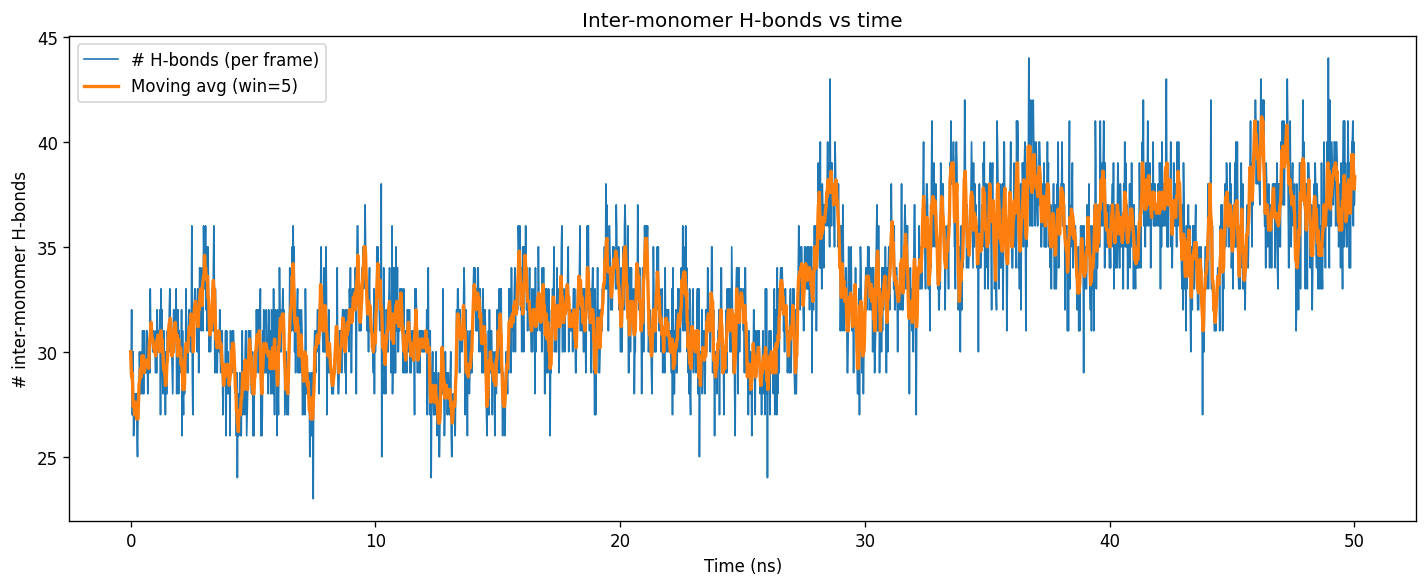

In [5]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ========= EDIT THIS =========
PATH = "6W3C_dephos_Hb_50ns.csv"     # your HBonds output file (the one you pasted)
SMOOTH_WIN = 5                 # moving-average window in frames (0/None to disable)
# =============================

# -- read whole file --
with open(PATH, "r", encoding="utf-8", errors="ignore") as f:
    txt = f.read()

# -- meta for time axis (optional) --
def get_num(key, default=None):
    m = re.search(rf'\b{key}\s*=\s*([-+]?\d+(?:\.\d+)?)', txt)
    return float(m.group(1)) if m else default

first_time_ps = get_num("TrajectoryFirstTime", 0.0)
interval_ps   = get_num("TrajectoryInterval_ps", None)

# -- extract the balanced 'Result = [ ... ]' block safely --
start_m = re.search(r'\bResult\s*=\s*\[', txt)
if not start_m:
    raise ValueError("Could not find 'Result = [' in the file.")

start = start_m.end() - 1  # position of the '['
depth = 0
end   = None
for i, ch in enumerate(txt[start:], start=start):
    if ch == '[':
        depth += 1
    elif ch == ']':
        depth -= 1
        if depth == 0:
            end = i
            break

if end is None:
    raise ValueError("Unbalanced brackets in Result block.")

block = txt[start+1:end]  # inside of the outermost [ ... ]

# -- split into per-frame groups at top level: [ [i j] [k l] ... ] --
frames_str = []
depth = 0
curr_start = None
for idx, ch in enumerate(block):
    if ch == '[':
        if depth == 0:
            curr_start = idx
        depth += 1
    elif ch == ']':
        depth -= 1
        if depth == 0 and curr_start is not None:
            frames_str.append(block[curr_start:idx+1])
            curr_start = None

if not frames_str:
    raise ValueError("Found Result block, but no per-frame groups like [ [i j] [k l] ... ].")

# -- count pairs per frame: look for [int int] inside each frame group --
pair_pat = re.compile(r'\[\s*\d+\s+\d+\s*\]')
counts = [len(pair_pat.findall(fr)) for fr in frames_str]

# -- build x-axis (time if interval given; else frame index) --
frames_idx = np.arange(len(counts))
if interval_ps is not None:
    time_ps = first_time_ps + frames_idx * interval_ps
    x = time_ps / 1000.0
    xlabel = "Time (ns)"
else:
    x = frames_idx.astype(float)
    xlabel = "Frame index (no timing metadata found)"

# -- stats --
mean_c = float(np.mean(counts))
med_c  = float(np.median(counts))
min_c, max_c = int(np.min(counts)), int(np.max(counts))
print(f"Frames: {len(counts)} | mean={mean_c:.2f}, median={med_c:.2f}, min–max={min_c}–{max_c}")
if interval_ps is not None:
    print(f"Spacing: {interval_ps} ps | Window ~ {(x[-1]-x[0]):.2f} ns")

# -- optional smoothing --
counts_smooth = None
if SMOOTH_WIN and SMOOTH_WIN > 1:
    s = pd.Series(counts, dtype=float).rolling(window=SMOOTH_WIN, center=True, min_periods=1).mean().to_numpy()
    counts_smooth = s

# -- plot --
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["figure.dpi"] = 120

plt.figure()
plt.plot(x, counts, linewidth=1, label="# H-bonds (per frame)")
if counts_smooth is not None:
    plt.plot(x, counts_smooth, linewidth=2, label=f"Moving avg (win={SMOOTH_WIN})")
plt.xlabel(xlabel)
plt.ylabel("# inter-monomer H-bonds")
plt.title("Inter-monomer H-bonds vs time")
plt.legend()
plt.tight_layout()
plt.show()


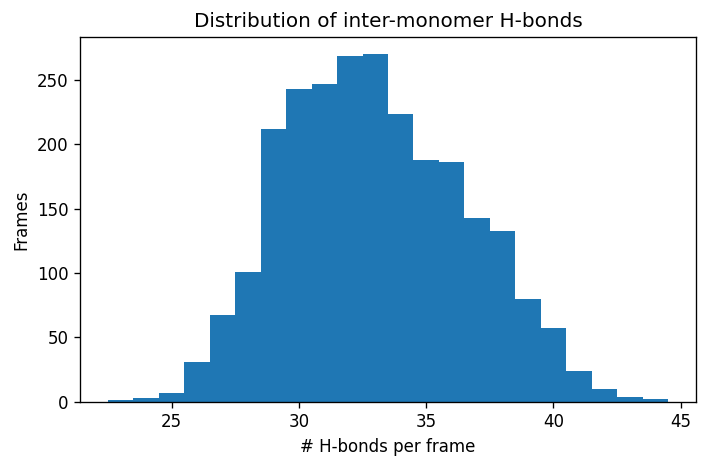

In [6]:
plt.figure(figsize=(6,4), dpi=120)
plt.hist(counts, bins=range(min_c, max_c+2), align="left")
plt.xlabel("# H-bonds per frame")
plt.ylabel("Frames")
plt.title("Distribution of inter-monomer H-bonds")
plt.tight_layout()
plt.show()

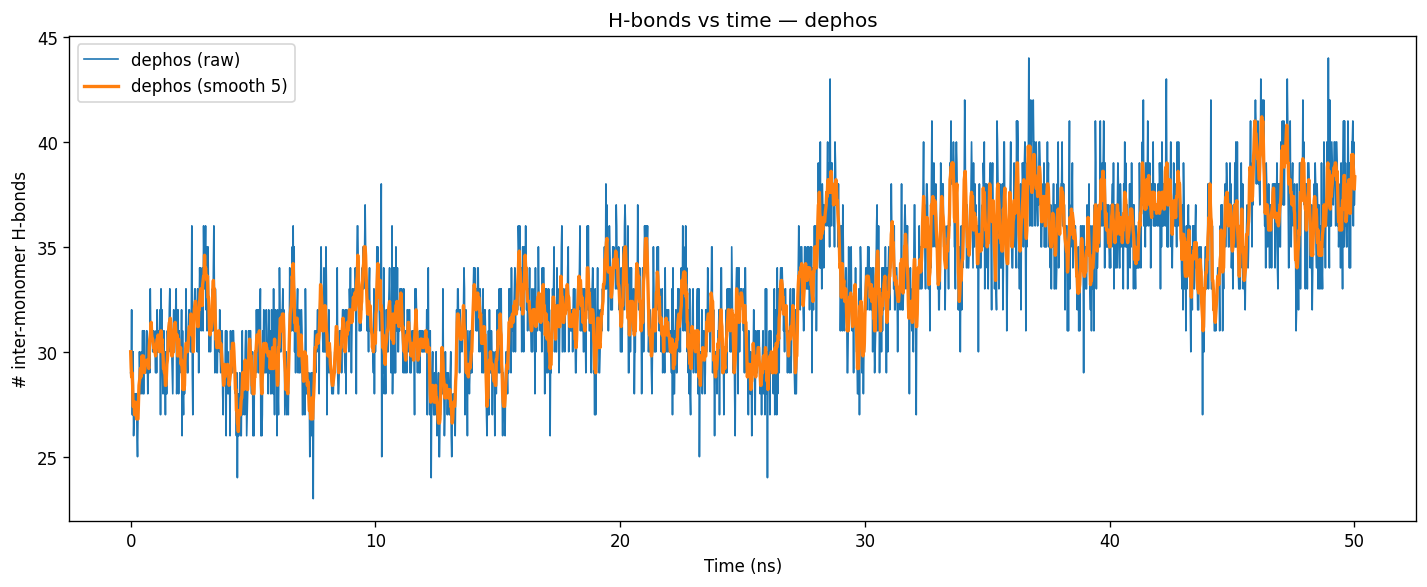

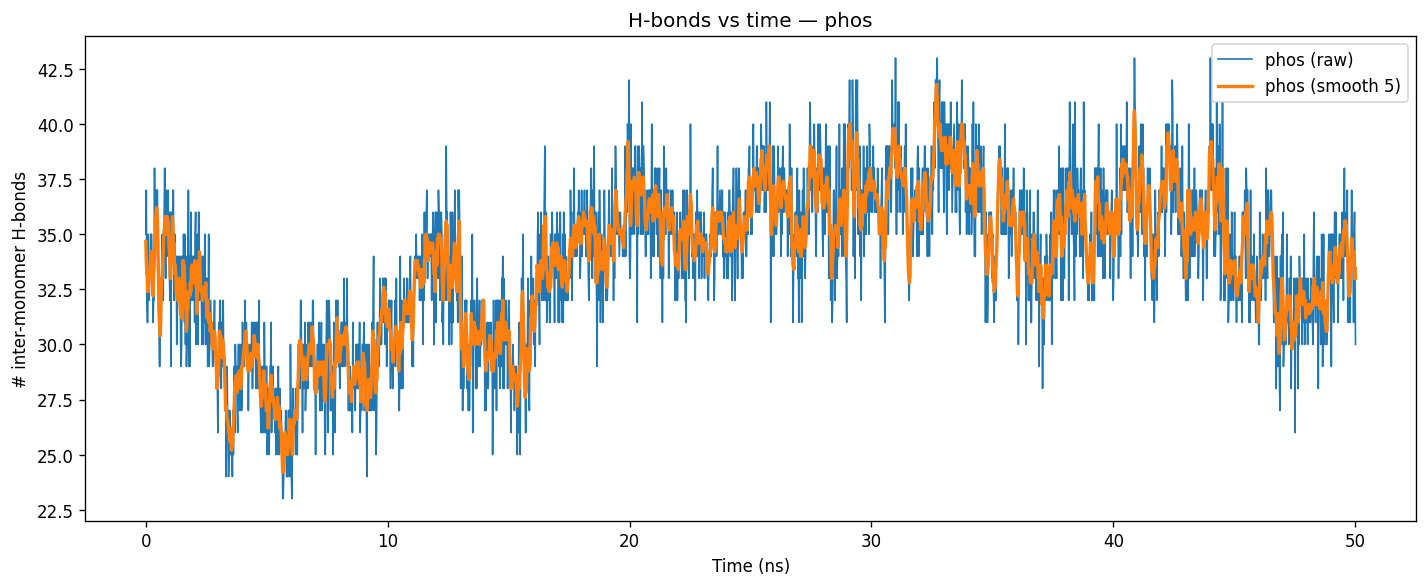

Meta dephos: frames=2502, interval_ps=19.998
Meta phos: frames=2502, interval_ps=19.998



,n,mean,median,std,min,p05,p95,max,iqr,frac_above_median
dephos,2502,33.024,33.0,3.521,23.0,28.0,39.0,44.0,6.0,0.420
phos,2502,33.807,34.0,3.593,23.0,27.0,39.0,43.0,5.0,0.474


In [8]:
import re, numpy as np, pandas as pd, matplotlib.pyplot as plt

# ========= EDIT THESE =========
PATH1 = "6W3C_dephos_Hb_50ns.csv"   # file 1 (with Result = [ [ [i j] ... ] per frame ])
PATH2 = "6W3C_phos_Hb_50ns.csv"   # file 2
LABEL1 = "dephos"
LABEL2 = "phos"
SMOOTH_WIN = 5              # moving-average window in frames (0/None to disable)
# =============================

# --------- parser ----------
def parse_hbond_file(path):
    """
    Parse a Desmond HBonds analyzer output that contains:
      Result = [ [ [i j] [k l] ... ]    # frame 0
                 [ [..] [..] ... ]      # frame 1
                 ...
               ]
    and (optionally)
      TrajectoryFirstTime = <ps>
      TrajectoryInterval_ps = <ps>
    Returns: DataFrame with columns: frame, time_ns, hbonds; and a meta dict.
    """
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        txt = f.read()

    # meta for time axis
    def get_num(key, default=None):
        m = re.search(rf'\b{key}\s*=\s*([-+]?\d+(?:\.\d+)?)', txt)
        return float(m.group(1)) if m else default

    first_time_ps = get_num("TrajectoryFirstTime", 0.0)
    interval_ps   = get_num("TrajectoryInterval_ps", None)

    # find the balanced Result = [ ... ] block
    start_m = re.search(r'\bResult\s*=\s*\[', txt)
    if not start_m:
        raise ValueError(f"{path}: could not find 'Result = ['.")
    start = start_m.end() - 1  # at the '['
    depth, end = 0, None
    for i, ch in enumerate(txt[start:], start=start):
        if ch == '[':
            depth += 1
        elif ch == ']':
            depth -= 1
            if depth == 0:
                end = i
                break
    if end is None:
        raise ValueError(f"{path}: unbalanced brackets in Result block.")
    block = txt[start+1:end]

    # split into per-frame groups at top level
    frames_str, depth, curr_start = [], 0, None
    for idx, ch in enumerate(block):
        if ch == '[':
            if depth == 0:
                curr_start = idx
            depth += 1
        elif ch == ']':
            depth -= 1
            if depth == 0 and curr_start is not None:
                frames_str.append(block[curr_start:idx+1])
                curr_start = None
    if not frames_str:
        raise ValueError(f"{path}: found Result, but no per-frame groups like [ [i j] ... ].")

    # count pairs per frame
    pair_pat = re.compile(r'\[\s*\d+\s+\d+\s*\]')
    counts = [len(pair_pat.findall(fr)) for fr in frames_str]

    frames_idx = np.arange(len(counts))
    if interval_ps is not None:
        time_ps = first_time_ps + frames_idx * interval_ps
        time_ns = time_ps / 1000.0
    else:
        time_ns = frames_idx.astype(float)  # frame index if no timing metadata

    df = pd.DataFrame({"frame": frames_idx, "time_ns": time_ns, "hbonds": counts})
    meta = {"first_time_ps": first_time_ps, "interval_ps": interval_ps, "n_frames": len(df)}
    return df, meta

def stats_summary(series):
    s = pd.Series(series, dtype=float)
    return {
        "n": int(s.size),
        "mean": float(s.mean()),
        "median": float(s.median()),
        "std": float(s.std(ddof=1)) if s.size > 1 else 0.0,
        "min": float(s.min()),
        "p05": float(s.quantile(0.05)),
        "p95": float(s.quantile(0.95)),
        "max": float(s.max()),
        "iqr": float(s.quantile(0.75) - s.quantile(0.25)),
    }

# --------- parse both files ----------
df1, meta1 = parse_hbond_file(PATH1)
df2, meta2 = parse_hbond_file(PATH2)

# optional smoothing
if SMOOTH_WIN and SMOOTH_WIN > 1:
    df1["hbonds_smooth"] = pd.Series(df1["hbonds"]).rolling(window=SMOOTH_WIN, center=True, min_periods=1).mean()
    df2["hbonds_smooth"] = pd.Series(df2["hbonds"]).rolling(window=SMOOTH_WIN, center=True, min_periods=1).mean()

# --------- plots (two separate figures) ----------
plt.rcParams["figure.figsize"] = (12,5)
plt.rcParams["figure.dpi"] = 120

# Figure 1
plt.figure()
plt.plot(df1["time_ns"], df1["hbonds"], linewidth=1, label=f"{LABEL1} (raw)")
if "hbonds_smooth" in df1:
    plt.plot(df1["time_ns"], df1["hbonds_smooth"], linewidth=2, label=f"{LABEL1} (smooth {SMOOTH_WIN})")
xlabel = "Time (ns)" if meta1["interval_ps"] is not None else "Frame index"
plt.xlabel(xlabel)
plt.ylabel("# inter-monomer H-bonds")
plt.title(f"H-bonds vs time — {LABEL1}")
plt.legend()
plt.tight_layout()
plt.show()

# Figure 2
plt.figure()
plt.plot(df2["time_ns"], df2["hbonds"], linewidth=1, label=f"{LABEL2} (raw)")
if "hbonds_smooth" in df2:
    plt.plot(df2["time_ns"], df2["hbonds_smooth"], linewidth=2, label=f"{LABEL2} (smooth {SMOOTH_WIN})")
xlabel = "Time (ns)" if meta2["interval_ps"] is not None else "Frame index"
plt.xlabel(xlabel)
plt.ylabel("# inter-monomer H-bonds")
plt.title(f"H-bonds vs time — {LABEL2}")
plt.legend()
plt.tight_layout()
plt.show()

# --------- numeric comparison ----------
stat1 = stats_summary(df1["hbonds"])
stat2 = stats_summary(df2["hbonds"])

# fraction of frames above own median (a quick measure of skew/persistence)
stat1["frac_above_median"] = float((df1["hbonds"] > stat1["median"]).mean())
stat2["frac_above_median"] = float((df2["hbonds"] > stat2["median"]).mean())

# print tables
print(f"Meta {LABEL1}: frames={meta1['n_frames']}, interval_ps={meta1['interval_ps']}")
print(f"Meta {LABEL2}: frames={meta2['n_frames']}, interval_ps={meta2['interval_ps']}\n")

comp = pd.DataFrame([stat1, stat2], index=[LABEL1, LABEL2])
display(comp.round(3))

# Optional: if you want an overlay for quick visual compare, uncomment below
# plt.figure(figsize=(12,5), dpi=120)
# plt.plot(df1["time_ns"], df1.get("hbonds_smooth", df1["hbonds"]), label=LABEL1)
# plt.plot(df2["time_ns"], df2.get("hbonds_smooth", df2["hbonds"]), label=LABEL2)
# plt.xlabel("Time (ns)" if (meta1["interval_ps"] or meta2["interval_ps"]) else "Frame index")
# plt.ylabel("# inter-monomer H-bonds")
# plt.title("H-bonds vs time — overlay")
# plt.legend()
# plt.tight_layout()
# plt.show()
